In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import afterglowpy as grb

In [2]:
def loadDataFromFile(filename):
    """
    Load GRB afterglow data from a .txt file.
    
    Arguments
    
        filename: the name (and path) to the data file.
        
    Returns
        
        t: array
            observed times in seconds
        nu: array
            observed frequency in Hz
        Fnu: array
            observed flux in mJy
        Ferr: array
            uncertainty in observed flux in mJy
    """
    
    
    t_all, nu_all, Fnu_all, Ferr_all, ul_all = np.loadtxt(filename, usecols=[0,1,2,3,4], unpack=True)
    
    detections = (ul_all == 0.0)
    t_det = t_all[detections]
    nu_det = nu_all[detections]
    Fnu_det = Fnu_all[detections]
    Ferr_det = Ferr_all[detections]
    
    return t_det, nu_det, Fnu_det, Ferr_det

In [3]:
t_data, nu_data, Fnu_data, Ferr_data = loadDataFromFile("160509A_data.txt")

## Notes to self

What does this code do?

Given a text file with the data and using Geoff's load data function, the data splits itself into radio, optical and  x-ray signals based on the wavelength frequency using a set parameter. Each item has four elements: frequency (nu), time (t), flux in mJy (Fnu), and uncertainty in flux (Ferr). It produces models of each of these three signal types (also using set parameters), and it plots all eight variables (4 from the model and 4 from the data) and plots them.

What do I want v.2 to do?
  
I want to be able to set variables for the discriminatory parameters in the function, so they're modifiable outside of them. In the same vein, I want to change the mechanism they use to optimize it (ie using & functions instead of for loops). I also want to make the internal variables in a function clearer, and change some things about the plotting to make the graph cleaner and more understandable. 

## Section 1: Slicing functions and separating the data

In [4]:
#limits

nuR_lo = 30
nuR_hi = 10**11
nuO_lo = 10**13
nuO_hi = 10**15
nuX_lo = 10**16
nuX_hi = 10**20

In [5]:
def isoRSignals(time, freq, flux, ferr):
    timeR = time[(nu_data>nuR_lo) & (nu_data<nuR_hi)]
    freqR = freq[(nu_data>nuR_lo) & (nu_data<nuR_hi)]
    fluxR = flux[(nu_data>nuR_lo) & (nu_data<nuR_hi)]
    ferrR = ferr[(nu_data>nuR_lo) & (nu_data<nuR_hi)]
    return timeR, freqR, fluxR, ferrR

tR_data, nuR_data, FnuR_data, FerrR_data = isoRSignals(t_data, nu_data, Fnu_data, Ferr_data)

In [6]:
def isoOSignals(time, freq, flux, ferr):
    timeO = time[(nu_data>nuO_lo) & (nu_data<nuO_hi)]
    freqO = freq[(nu_data>nuO_lo) & (nu_data<nuO_hi)]
    fluxO = flux[(nu_data>nuO_lo) & (nu_data<nuO_hi)]
    ferrO = ferr[(nu_data>nuO_lo) & (nu_data<nuO_hi)]
    return timeO, freqO, fluxO, ferrO

tO_data, nuO_data, FnuO_data, FerrO_data = isoOSignals(t_data, nu_data, Fnu_data, Ferr_data)

In [7]:
def isoXSignals(time, freq, flux, ferr):
    timeX = time[(nu_data>nuX_lo) & (nu_data<nuX_hi)]
    freqX = freq[(nu_data>nuX_lo) & (nu_data<nuX_hi)]
    fluxX = flux[(nu_data>nuX_lo) & (nu_data<nuX_hi)]
    ferrX = ferr[(nu_data>nuX_lo) & (nu_data<nuX_hi)]
    return timeX, freqX, fluxX, ferrX

tX_data, nuX_data, FnuX_data, FerrX_data = isoXSignals(t_data, nu_data, Fnu_data, Ferr_data)

print(tX_data)

In [8]:
def isoSignal(t_data, nu_data, Fnu_data, Ferr_data):
    tR_data, nuR_data, FnuR_data, FerrR_data = isoRSignals(t_data, nu_data, Fnu_data, Ferr_data)
    tO_data, nuO_data, FnuO_data, FerrO_data = isoOSignals(t_data, nu_data, Fnu_data, Ferr_data)
    tX_data, nuX_data, FnuX_data, FerrX_data = isoXSignals(t_data, nu_data, Fnu_data, Ferr_data)
    return tR_data, nuR_data, FnuR_data, FerrR_data, tO_data, nuO_data, FnuO_data, FerrO_data,tX_data, nuX_data, FnuX_data, FerrX_data

In [9]:
(tR_data, nuR_data, FnuR_data, FerrR_data, 
tO_data, nuO_data, FnuO_data, FerrO_data, 
tX_data, nuX_data, FnuX_data, FerrX_data) = isoSignal(t_data, nu_data, Fnu_data, Ferr_data)

## Section 2: Model values

In [10]:
Z = {'jetType': grb.jet.TopHat, #type of jet structure
   'specType':0,       #type of spectrum
   'thetaObs':0,       #observer angle(radians)
   'E0': 1.0e53,       #isotropic energy (erg)
   'thetaCore': 0.1,   #jet opening angle (radians)
   'n0': 1.0,          #ambient ISM density (cm^3{-3})
   'p': 2.2,           #electron energy slope (no units)
   'epsilon_e': 0.1,   #fraction of energy in accelerated electrons (no units)
   'epsilon_B': 0.1,   #fraction of energy in magnetic field (no units)
   'ksiN': 1.0,        #luminosity distancde (cm)
   'dL': 1.0e28,       #redshift (no units)
   'z': 0.5
  }

In [11]:
tR_model = np.geomspace(1.0e3, 1.0e6, 1000)
nuR_model = np.empty(tR_model.shape)
nuR_model[:] = 10**6

FnuR_model = grb.fluxDensity(tR_model, nuR_model, **Z)

In [12]:
tO_model = np.geomspace(1.0e3, 1.0e6, 1000)
nuO_model = np.empty(tO_model.shape)
nuO_model[:] = 10**14

FnuO_model = grb.fluxDensity(tO_model, nuO_model, **Z)

In [13]:
tX_model = np.geomspace(1.0e3, 1.0e6, 1000)
nuX_model = np.empty(tX_model.shape)
nuX_model[:] = 10**17

FnuX_model = grb.fluxDensity(tX_model, nuX_model, **Z)

## Section 3: Plotting the data

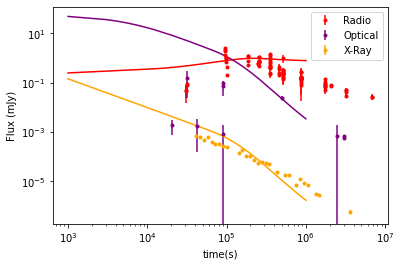

In [14]:
plt.errorbar(tR_data, FnuR_data, FerrR_data, ls = "", marker = ".", label = "Radio", color = "red")
plt.errorbar(tO_data, FnuO_data, FerrO_data, ls = "", marker = ".", label = "Optical", color = "purple")
plt.errorbar(tX_data, FnuX_data, FerrX_data, ls = "", marker = ".", label = "X-Ray", color = "orange")
plt.plot(tR_model, FnuR_model, color = "red")
plt.plot(tO_model, FnuO_model, color = "purple")
plt.plot(tX_model, FnuX_model, color = "orange")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time(s)')
plt.ylabel('Flux (mJy)')
plt.legend()
plt.show()